## Environment Simulation

In [9]:
from gym.wrappers import FlattenObservation
import numpy as np
import pandas as pd 
import scipy
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import gym_electric_motor as gem
from gym_electric_motor.reference_generators import MultipleReferenceGenerator, ConstReferenceGenerator, \
    WienerProcessReferenceGenerator, StepReferenceGenerator
from gym_electric_motor.visualization import MotorDashboard
from gym_electric_motor.visualization.motor_dashboard_plots import MeanEpisodeRewardPlot
from gym_electric_motor.physical_systems.mechanical_loads import ConstantSpeedLoad
from gym.core import Wrapper
from gym.spaces import Box, Tuple
from gym_electric_motor.constraints import SquaredConstraint
from gym_electric_motor.physical_system_wrappers import DqToAbcActionProcessor, DeadTimeProcessor
from classic_controllers import Controller
from externally_referenced_state_plot import ExternallyReferencedStatePlot

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Define a reference generator for torque
torque_generator = WienerProcessReferenceGenerator(reference_state='torque')

# The MultipleReferenceGenerator allows to apply these references simultaneously
# rg = MultipleReferenceGenerator([d_generator, q_generator])

# Set the electric parameters of the motor
motor_parameter = dict(
    r_s=15e-3, l_d=0.37e-3, l_q=1.2e-3, psi_p=65.6e-3, p=3, j_rotor=0.06
)

# Change the motor operational limits (important when limit violations can terminate and reset the environment)
limit_values = dict(
    i=160*1.41,
    omega=12000 * np.pi / 30,
    u=450
)

# Change the motor nominal values
nominal_values = {key: 0.7 * limit for key, limit in limit_values.items()}
physical_system_wrappers = (
    DeadTimeProcessor(),
    # DqToAbcActionProcessor.make('PMSM'),
)

In [11]:
# Create the environment

states = ['omega', 'torque', 'i', 'u', 'u_sup']
external_ref_plots = [ExternallyReferencedStatePlot(state) for state in states]
env = gem.make(
    "Cont-TC-PermExDc-v0", 
    visualization=MotorDashboard(additional_plots=external_ref_plots, update_interval=100, time_plot_width=2000), 
    reference_generator=torque_generator, 
    # motor= dict(
    #     motor_parameter={'r_a': 0.010, 'l_a': 1.5e-05, 'psi_e': 0.165, 'j_rotor': 0.025}
    #     ),
)

In [12]:
env.physical_system.electrical_motor.motor_parameter

{'r_a': 0.016, 'l_a': 1.9e-05, 'psi_e': 0.165, 'j_rotor': 0.025}

In [13]:
"""
    initialize the controller

    Args:
        environment                     gym-electric-motor environment
        external_ref_plots (optional)   plots of the environment, to plot all reference values
        stages (optional)               structure of the controller
        automated_gain (optional)       if True (default), the controller will be tune automatically
        a (optional)                    tuning parameter of the symmetrical optimum (default: 4)

"""
current_a_controller = {'controller_type': 'pi_controller', 'p_gain': 0, 'i_gain': 50}
speed_controller = {'controller_type': 'pi_controller', 'p_gain': 10, 'i_gain': 0.0}
current_e_controller = {'controller_type': 'pi_controller', 'p_gain': 5, 'i_gain': 300}

stages_a = [speed_controller]

controller = Controller.make(env, external_ref_plots=external_ref_plots)

In [14]:
i_limit = 160*1.41
omega_limit = 12000 * np.pi / 30
torque_limit = 38.0

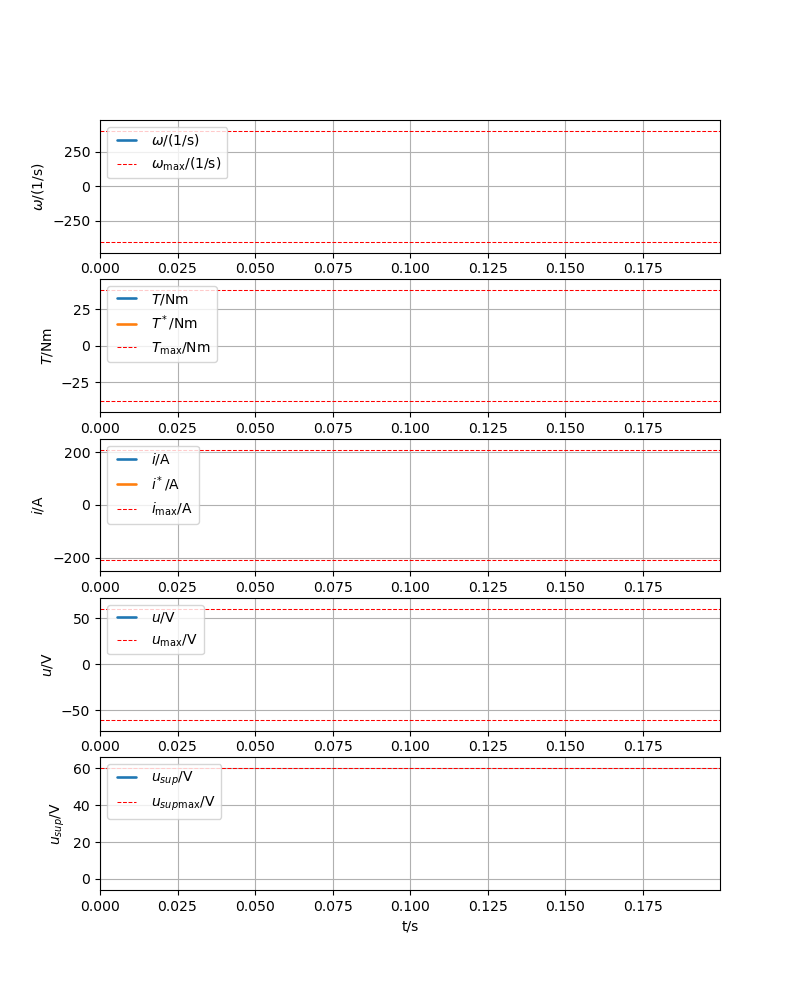

In [15]:
%matplotlib widget
visu = env.visualizations[0]
visu.initialize()

In [16]:
done = True

states, references = env.reset()
for i in range(2000):
   
    # control actions
    # for random sampling of seed sets
    # action = env.action_space.sample()
    # for optimization

  
    action = controller.control(states, references)
    env.render()  
    (states, references), rewards, done, _ = env.step(action)  
    print("action",action)
    print("states",states)
    print("references", references)
    print(done)

    if done:
        # Reset the environment
        # This is required initally or after an episode end due to a constraint violation in the env.
        states, references = env.reset()
        controller.reset()
    # visualize environment. Red vertical lines indicate a constraint violation and therefore, a reset environment.
    # Blue vertical lines indicate an additional reset by the user which is not due to a terminated episode.
    
# env.close()


action [-0.02099425456937597]
states [ 0.25       -0.38924542 -0.42687809 -0.02099425  1.        ]
references [-0.01644012]
False
action [0.15576137938327575]
states [ 0.25       -0.51461308 -0.56436644  0.15576138  1.        ]
references [-0.02655548]
False
action [0.18928241594383655]
states [ 0.25       -0.58577413 -0.64240742  0.18928242  1.        ]
references [-0.01719948]
False
action [0.213731222408754]
states [ 0.25       -0.6190368  -0.67888596  0.21373122  1.        ]
references [-0.01326756]
False
action [0.23164930831072406]
states [ 0.25       -0.62605003 -0.68657724  0.23164931  1.        ]
references [-0.00529344]
False
action [0.24486142908987724]
states [ 0.25       -0.61512234 -0.67459304  0.24486143  1.        ]
references [-0.00550593]
False
action [0.25467797962867833]
states [ 0.25       -0.592168   -0.64941945  0.25467798  1.        ]
references [0.00742601]
False
action [0.2620402233229973]
states [ 0.25       -0.56138583 -0.61566123  0.26204022  1.        ]
re